In [13]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
column_names = [
    'q1_s_est', 'q2_s_est', 'dq1_s_est', 'dq2_s_est',  # estSmall
    'q1_s_true', 'q2_s_true', 'dq1_s_true', 'dq2_s_true',  # s_StateHistory
    'u1_s', 'u2_s',  # s_uHistory
    'q1_l_est', 'q2_l_est', 'dq1_l_est', 'dq2_l_est',  # estLarge
    'q1_l_true', 'q2_l_true', 'dq1_l_true', 'dq2_l_true',  # l_StateHistory
    'u1_l', 'u2_l'  # l_uHistory
]
df = pd.read_csv("EKF_Simulation_AllData.csv", names=column_names, header=None)

In [7]:
df

,q1_s_est,q2_s_est,dq1_s_est,dq2_s_est,q1_s_true,q2_s_true,dq1_s_true,dq2_s_true,u1_s,u2_s,q1_l_est,q2_l_est,dq1_l_est,dq2_l_est,q1_l_true,q2_l_true,dq1_l_true,dq2_l_true,u1_l,u2_l
0,0.078992,0.000421,0.001937,-0.009488,0.087300,0.000000,0.000000,0.000000,0.000000,0.000000,0.194321,-0.005609,0.002870,0.016265,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.089828,-0.002531,0.011131,-0.000143,0.087563,-0.000895,-0.008472,-0.000275,9.043663,-14.111275,0.203965,-0.005155,-0.004663,0.022362,0.198791,-0.000691,-0.005936,-0.012004,20.000000,-10.443090
2,0.098502,0.001022,0.005292,-0.000610,0.085917,-0.002036,-0.016072,-0.000910,11.396080,-12.660541,0.208604,-0.008434,-0.013411,-0.007902,0.197000,-0.000736,-0.020086,-0.009155,20.000000,-26.890513
3,0.096597,-0.002839,-0.004946,-0.000028,0.085088,-0.000776,-0.020902,-0.002526,13.104166,-9.117900,0.197661,-0.004028,-0.023284,-0.004749,0.196668,-0.000736,-0.031114,-0.013955,20.000000,-20.103379
4,0.093369,-0.001199,-0.014262,-0.000189,0.086153,-0.000357,-0.023681,-0.002761,14.617626,-5.295183,0.198155,-0.004960,-0.033713,-0.009902,0.197171,-0.001016,-0.042718,-0.017376,20.000000,-20.562379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,0.005811,-0.018620,0.002721,0.001467,0.007709,-0.013770,0.004304,0.003442,-0.083337,-3.711233,0.008121,-0.057284,0.014621,0.010102,0.007731,-0.060986,0.011774,0.011908,-4.153446,-9.903618
2997,0.004899,-0.017048,0.001918,0.004097,0.007901,-0.013510,0.005389,0.002019,-0.711671,-1.809765,0.008750,-0.058066,0.014681,0.008965,0.007743,-0.061671,0.013341,0.015069,-3.793430,-10.665895
2998,0.005608,-0.016959,0.003220,0.004265,0.009121,-0.013490,0.004806,0.001377,-0.928762,-2.254292,0.007996,-0.058341,0.014413,0.011707,0.008852,-0.062412,0.013137,0.013081,-4.527030,-9.200260
2999,0.005907,-0.016431,0.004488,0.004725,0.007769,-0.013149,0.003259,0.001600,-1.266878,-2.433560,0.008126,-0.059380,0.014651,0.010977,0.011167,-0.061048,0.012546,0.013211,-4.367591,-9.813310


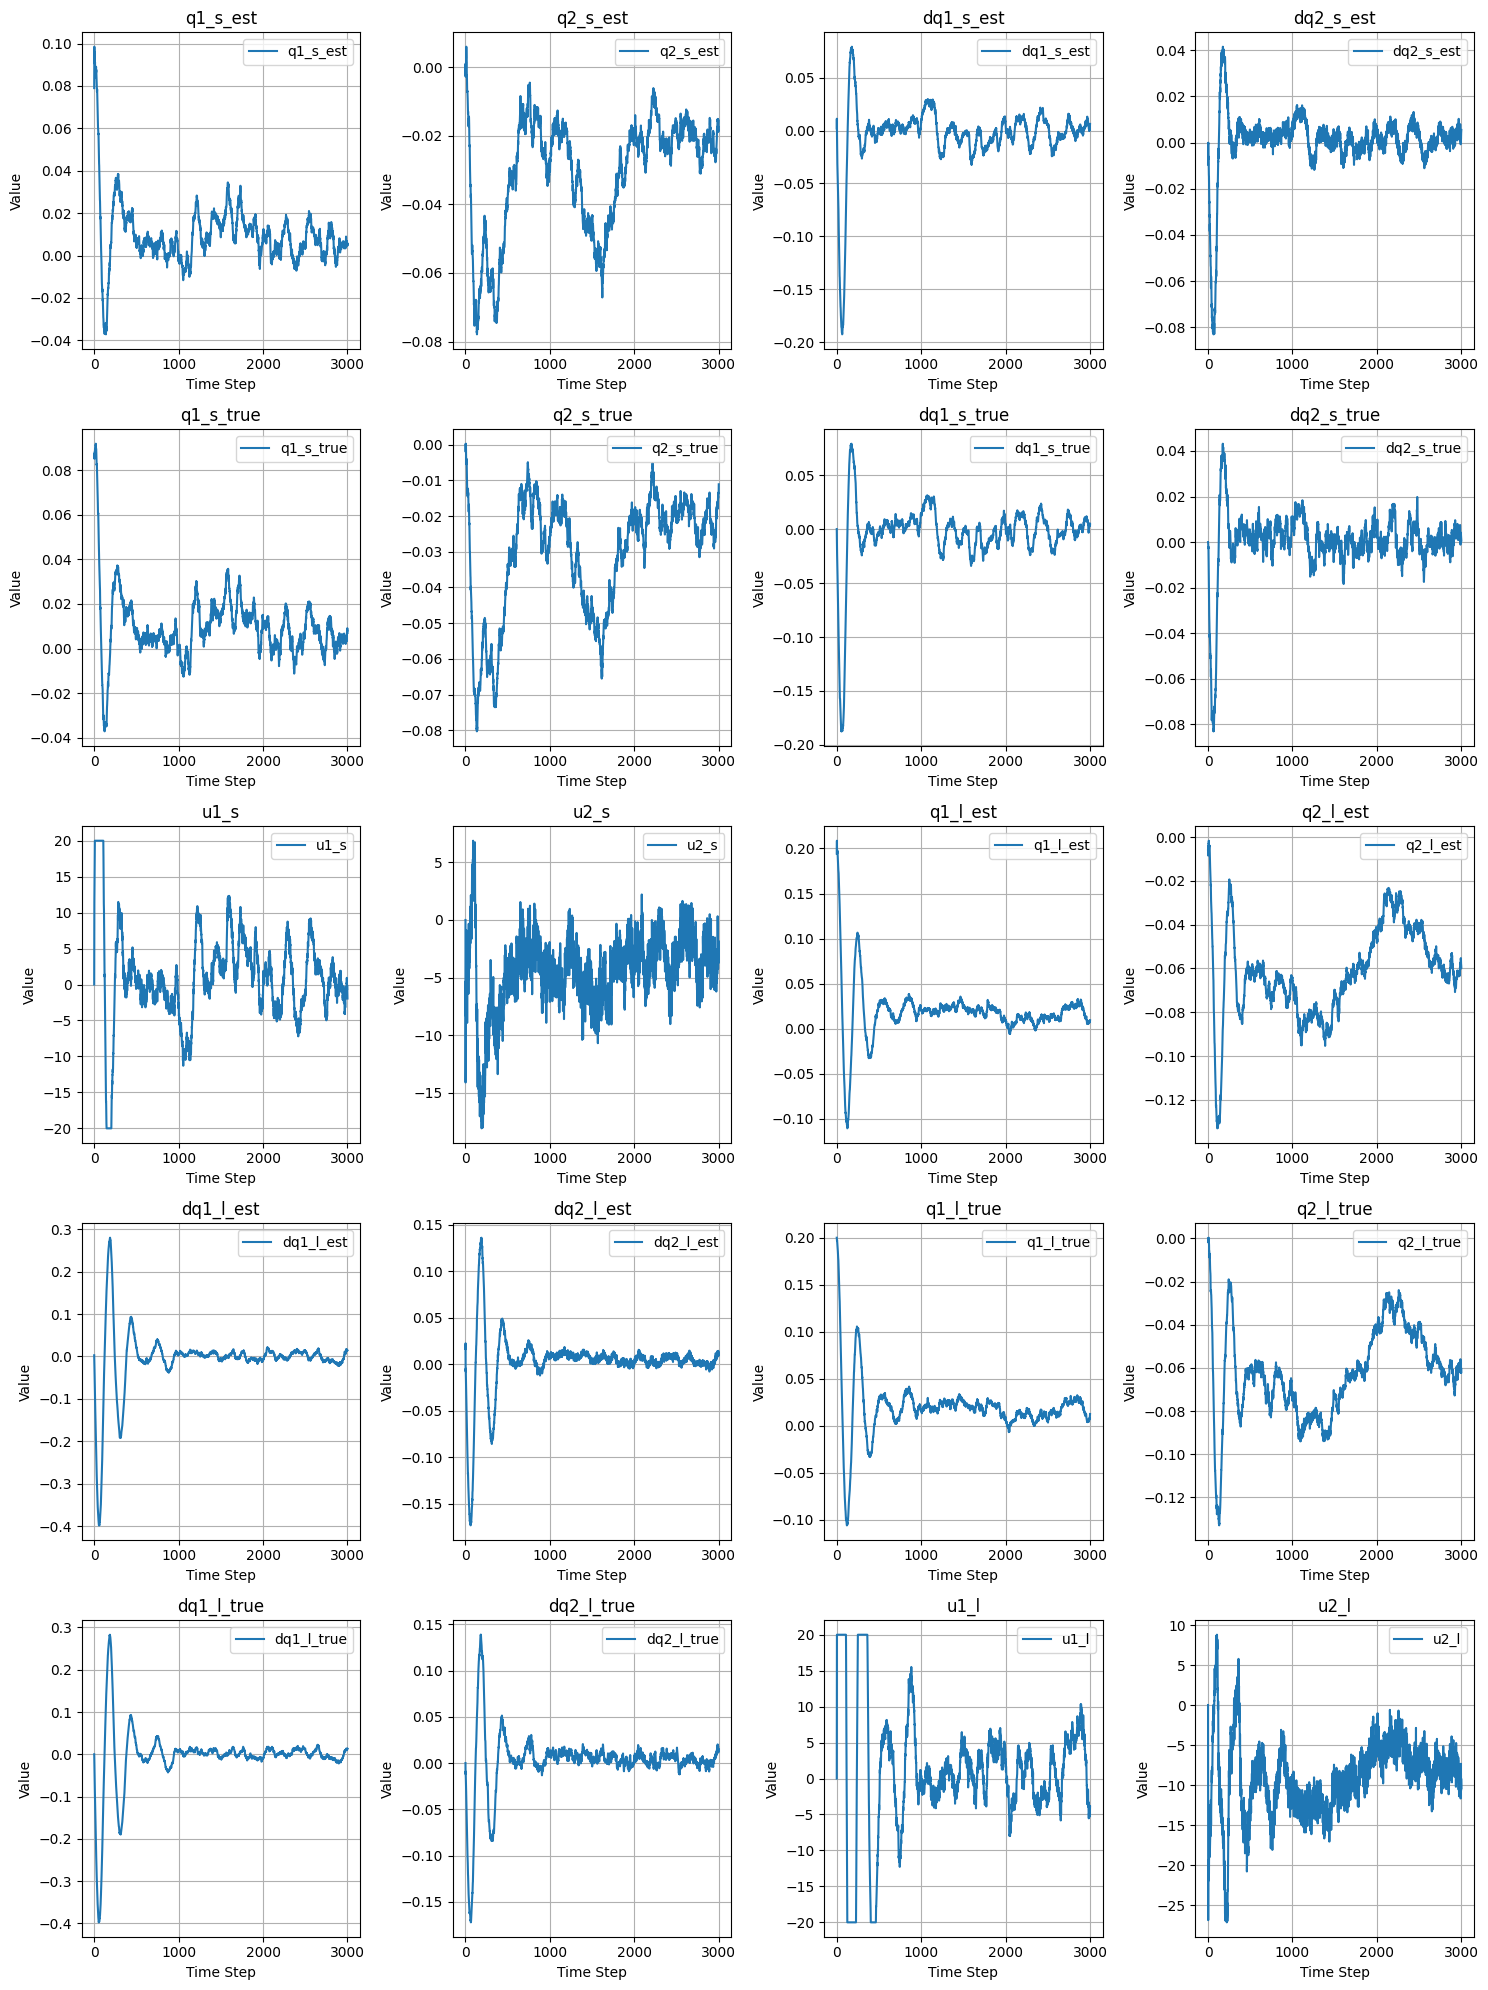

In [16]:
# データフレームのカラム数を取得
num_columns = len(df.columns)

# サブプロットのレイアウト設定（例: 4列）
num_rows = (num_columns // 4) + (num_columns % 4 > 0)  # 4列レイアウトの行数計算

# グラフのサイズ設定
plt.figure(figsize=(15, num_rows * 4))

# 各カラムをサブプロットとして描画
for i, column in enumerate(df.columns, 1):
    plt.subplot(num_rows, 4, i)  # 4列レイアウトでサブプロットを配置
    plt.plot(df[column], label=column)
    plt.title(column)
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.grid()
    plt.legend()

# 全体のレイアウト調整
plt.tight_layout()
plt.show()